In [31]:
from descriptive_statistics import DiabetesDataBase
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from utils import grid_search, halving_random_search, validate

## Hyperparameters

In [32]:
#SCALER = StandardScaler()
#SCALER = RobustScaler() # No difference to standard scaler for models I test except mlp
SCALER = QuantileTransformer(n_quantiles=334) # Slightly better result for regression and SVM

## Tensorboard

In [33]:
import torch
from torch.utils.tensorboard import SummaryWriter

log_folder = "logs"
writer = SummaryWriter(log_dir=log_folder)

## Read in and split data

In [34]:
csv_path = "diabetes.csv"
ddb = DiabetesDataBase(csv_path)
X_train, X_val, X_test, y_train, y_val, y_test = ddb.splitData()

Shape before removing values that are 0: (768, 9)
Shape after removing values that are 0: (532, 9)


## KNN Model

In [35]:
k_range = list(range(1, 31))
distance_metrics = ['euclidean','manhattan']
weight_options = ['uniform','distance']
param_grid = dict(classifier__n_neighbors=k_range,
                  classifier__metric=distance_metrics,
                  classifier__weights=weight_options)
knn_clf = KNeighborsClassifier()
pipe = Pipeline(steps=[("classifier", knn_clf)])
clf_GS = GridSearchCV(pipe, param_grid, return_train_score=True)
# training is done on the train set!!
clf_GS.fit(X_train, y_train)

# print best values for each parameter
for key in param_grid.keys():
    print(f'Best {key}:', clf_GS.best_estimator_.get_params()[f'{key}'])
print(clf_GS.best_estimator_.get_params()['classifier'])

Best classifier__n_neighbors: 15
Best classifier__metric: manhattan
Best classifier__weights: uniform
KNeighborsClassifier(metric='manhattan', n_neighbors=15)


Accuracy: 0.7333333333333333
Precision: [0.74468085 0.69230769]
Recall: [0.8974359  0.42857143]


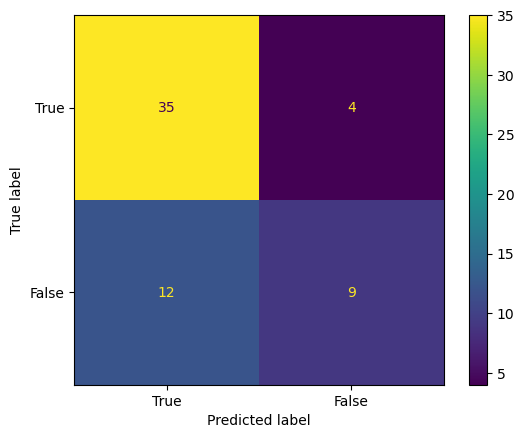

In [36]:
# use best estimator to predict on the validation set
y_pred = clf_GS.best_estimator_.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average=None)
recall = recall_score(y_val, y_pred, average=None)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# show confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[True,False])
disp.plot()

## Decision Tree

In [37]:
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

param_grid = dict(classifier__criterion=criterion,
                classifier__max_depth=max_depth)
print(param_grid)
decision_tree_clf = DecisionTreeClassifier()
pipe = Pipeline(steps=[("classifier", decision_tree_clf)])
clf_GS = GridSearchCV(pipe, param_grid, return_train_score=True)
# training is done on the train set!!
clf_GS.fit(X_train, y_train)

# print best values for each parameter
for key in param_grid.keys():
    print(f'Best {key}:', clf_GS.best_estimator_.get_params()[f'{key}'])
print(clf_GS.best_estimator_.get_params()['classifier'])

{'classifier__criterion': ['gini', 'entropy'], 'classifier__max_depth': [2, 4, 6, 8, 10, 12]}
Best classifier__criterion: entropy
Best classifier__max_depth: 4
DecisionTreeClassifier(criterion='entropy', max_depth=4)


Accuracy: 0.7166666666666667
Precision: [0.75  0.625]
Recall: [0.84615385 0.47619048]


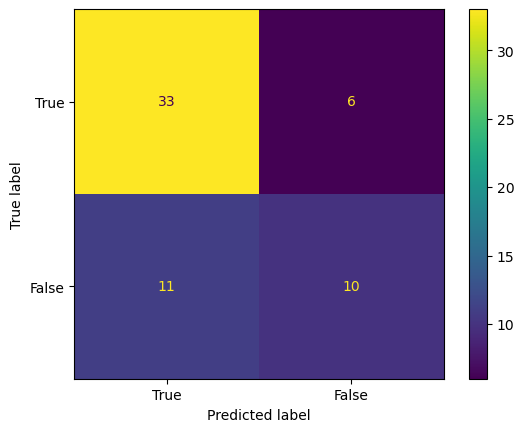

In [38]:
# use best estimator to predict on the validation set
y_pred = clf_GS.best_estimator_.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average=None)
recall = recall_score(y_val, y_pred, average=None)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# show confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[True,False])
disp.plot()

## Logistic Regression

LogisticRegression(penalty=None)
              precision    recall  f1-score   support

           0       0.86      0.79      0.83        39
           1       0.67      0.76      0.71        21

    accuracy                           0.78        60
   macro avg       0.76      0.78      0.77        60
weighted avg       0.79      0.78      0.79        60



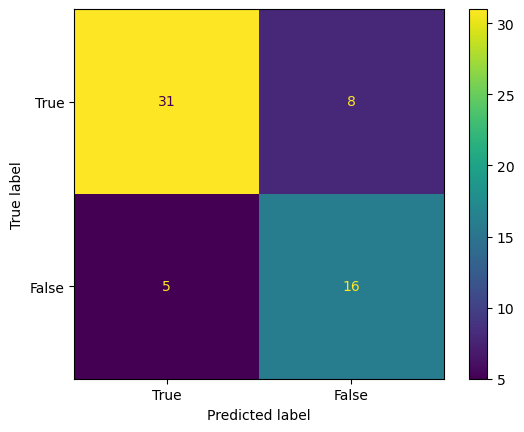

In [39]:
log_reg = LogisticRegression()

parameters = {
    "classifier__penalty": [None, "l2"]
}

reg_cls = grid_search(log_reg, SCALER, parameters)

reg_cls.fit(X_train, y_train)

print(reg_cls.best_estimator_.get_params()['classifier'])

log_reg_avg, log_reg_cm = validate(reg_cls, X_val, y_val)
writer.add_scalars("log_reg", log_reg_avg)
writer.flush()

## SVM

{'classifier__C': [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0], 'classifier__gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]}
SVC(gamma=0.4)
              precision    recall  f1-score   support

           0       0.82      0.79      0.81        39
           1       0.64      0.67      0.65        21

    accuracy                           0.75        60
   macro avg       0.73      0.73      0.73        60
weighted avg       0.75      0.75      0.75        60



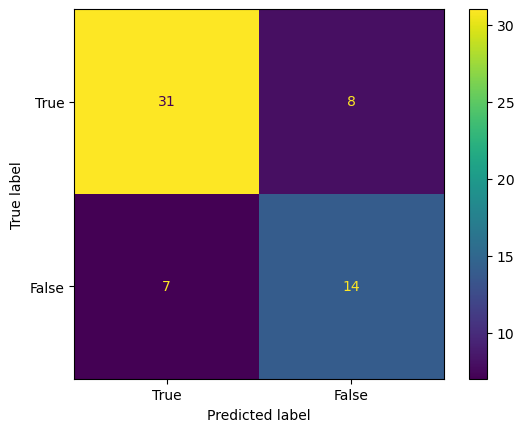

In [40]:
from sklearn.svm import SVC

svm = SVC()

parameters = {
    "classifier__C": [round(i*0.2, 1) for i in range(1, 21)],
    "classifier__gamma": [round(i*0.1, 1) for i in range(1, 21)]
}
print(parameters)


svm_cls = grid_search(svm, SCALER, parameters)
svm_cls.fit(X_train, y_train)
print(svm_cls.best_estimator_.get_params()['classifier'])

svm_avg, svm_cm = validate(svm_cls, X_val, y_val)
writer.add_scalars("svm", svm_avg)
writer.flush()

## MLP

{'classifier__solver': ['adam', 'sgd'], 'classifier__activation': ['relu', 'tanh', 'logistic'], 'classifier__learning_rate_init': [0.0001, 0.001, 0.01, 0.005], 'classifier__hidden_layer_sizes': [[10, 10], [100, 10], [50, 100, 50], [100], [10]], 'classifier__beta_1': [0.09, 0.091, 0.092, 0.093, 0.094], 'classifier__beta_2': [0.985, 0.988, 0.991, 0.994, 0.997]}


/Users/emillundin/anaconda3/envs/ptlightning/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2764: UserWarning: n_quantiles (334) is greater than the total number of samples (15). n_quantiles is set to n_samples.
  warnings.warn(
/Users/emillundin/anaconda3/envs/ptlightning/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2764: UserWarning: n_quantiles (334) is greater than the total number of samples (15). n_quantiles is set to n_samples.
  warnings.warn(
/Users/emillundin/anaconda3/envs/ptlightning/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2764: UserWarning: n_quantiles (334) is greater than the total number of samples (15). n_quantiles is set to n_samples.
  warnings.warn(
/Users/emillundin/anaconda3/envs/ptlightning/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2764: UserWarning: n_quantiles (334) is greater than the total number of samples (16). n_quantiles is set to n_samples.
  warnings.warn(
/Users/emillundin/anaconda3/envs

MLPClassifier(beta_1=0.093, beta_2=0.991, epsilon=1.2e-08,
              hidden_layer_sizes=[50, 100, 50], max_iter=30000, random_state=17,
              solver='sgd')
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        39
           1       0.62      0.62      0.62        21

    accuracy                           0.73        60
   macro avg       0.71      0.71      0.71        60
weighted avg       0.73      0.73      0.73        60



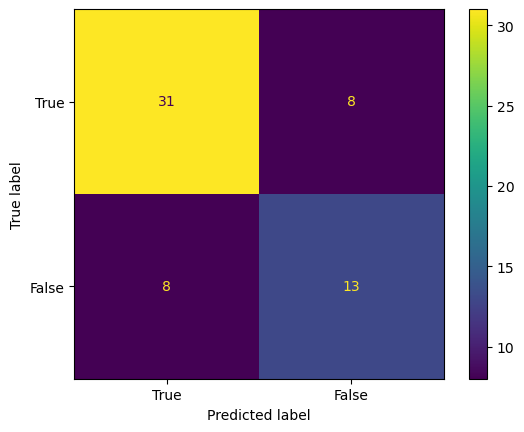

In [41]:
from sklearn.neural_network import MLPClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV


mlp = MLPClassifier(activation='relu', #relu
                    solver='adam', 
                    max_iter=30000, #300000
                    batch_size='auto',
                    learning_rate_init=0.001,
                    # Early stopping kinda does CV too https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
                    # But got worse results
                    early_stopping=False, # False
                    shuffle=True,
                    random_state=17,
                    alpha=0.0001, # L2 loss strenght
                    beta_1=0.93, # 0.9 org Exponential decay rate for estimates of first moment vector in adam
                    beta_2=0.99, # 0.999 org Exponential decay rate for estimates of second moment vector in adam
                    epsilon=12e-9 # 1e-8 org Value for numerical stability in adam.
                    )

"""
# These found acc: 77 f1 74,76
# MLPClassifier(batch_size=64, beta_1=0.93, beta_2=0.99, epsilon=1.2e-08, max_iter=30000, random_state=17, solver='sgd')
parameters = {
    "classifier__solver": ["adam", "sgd"],
    "classifier__batch_size": [4, 16, 32, 64],
    "classifier__activation": ["relu", "tanh", "logistic"],
    "classifier__learning_rate_init": [0.0001, 0.001, 0.01, 0.005],
}

# These found acc 75, f1 72, 75
# MLPClassifier(beta_1=0.09, beta_2=0.988, epsilon=1.2e-08, hidden_layer_sizes=[10], max_iter=30000, random_state=17)
parameters = {
    "classifier__hidden_layer_sizes": [[10,10], [100,10], [50,100,50], [100], [10]],
    "classifier__beta_1": [round(i*0.001, 3) for i in range(90, 95)],
    "classifier__beta_2": [round(i*0.001, 4) for i in range(985, 999, 3)]
}
"""
parameters = {
    "classifier__solver": ["adam", "sgd"],
    #"classifier__batch_size": [4, 16, 32, 64],
    "classifier__activation": ["relu", "tanh", "logistic"],
    "classifier__learning_rate_init": [0.0001, 0.001, 0.01, 0.005],
    "classifier__hidden_layer_sizes": [[10,10], [100,10], [50,100,50], [100], [10]],
    "classifier__beta_1": [round(i*0.001, 3) for i in range(90, 95)],
    "classifier__beta_2": [round(i*0.001, 4) for i in range(985, 999, 3)]
}
print(parameters)

mlp_cls = halving_random_search(mlp, SCALER, parameters)

mlp_cls.fit(X_train, y_train)

print(mlp_cls.best_estimator_.get_params()['classifier'])

mlp_avg, mlp_cm = validate(mlp_cls, X_val, y_val)
writer.add_scalars("mlp", mlp_avg)
writer.flush()
writer.close()

In [42]:
%load_ext tensorboard
%tensorboard --logdir=logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 31847), started 0:08:19 ago. (Use '!kill 31847' to kill it.)